# Geoprocessing and Mapping

Agenda:

- reading shapefiles
- managing coordinate projections
- creating maps
- geoprocessing: dissolve, spatial joins and overlays

We will be making extensive use of Geopandas, a geospatial extension of Pandas.  Installation of this ranges from very easy to very challenging, and depends on your computer and what is already installed on it, which makes it extremely difficult to diagnose installation problems.  I suggest using a clean install of Anaconda or setting up a virtual environment to do this installation, and use Pip install, not Conda.  Installation is addressed for geopandas and for rtree which we will use for some geoprocessing operations.

### Background reference material on coordinate sytems and projections

##### Some terminology:
- **geoid**: (that's *gee-oid*) the surface of the earth's gravity field, which approximates mean sea level
- **spheroid** or **ellipsoid** (interchangeable terms): a model that smoothly approximates the geoid
- **datum**: based on spheroid but incorporates local variations in the shape of the Earth. Used to describe a point on the Earth's surface, such as in latitude and longitude.
  - NAD83 (North American Datum 1983) uses the GRS80 spheroid
  - WGS84 (World Geodetic Survey 1984 datum) uses the WGS84 spheroid
  - The latitude and longitude coordinates of some point differ slightly based on the datum. GPS uses WGS84.
- **coordinate reference system** (CRS) or spatial reference system (SRS): a series of parameters that [define](http://spatialreference.org/) the coordinate system and spatial extent (aka, domain) of some dataset.
- **geographic coordinate system** (GCS): specifies a datum, spheroid, units of measure (such as meters), and a prime meridian
- **projected coordinate system** or map projection: projects a map of the Earth's 3-D spherical surface onto a flat surface that can be measured in units like meters. Here's a [list of projections](https://en.wikipedia.org/wiki/List_of_map_projections).
- **eastings** and **northings**: the x and y coordinates of a projected map, usually measured in meters
- **false origin**: the 0,0 origin point from which eastings and northings are measured on the map, usually the lower left corner rather than the center
- **PROJ.4**: a library to convert/project spatial data with consistent CRS [parameter names](https://github.com/OSGeo/proj.4/wiki/GenParms)

##### Common CRS parameters (and their PROJ.4 names):
- datum (datum)
- ellipse (ellps)
- projection (proj)
  - the name of the projected coordinate system, such as Albers Equal Area (aea) or Lambert Conformal Conic (lcc)
- standard parallels (lat_1, lat_2)
  - where the projection surface touches the globe - at the standard parallels, the projection shows no distortion
- central meridian and latitude of origin (lon_0, lat_0)
  - the origin of the projection's x and y coordinates (eastings and northings) - usually the center of the map projection
- false easting and false northing (x_0, y_0)
  - offsets to add to all your eastings and northings - usually used to make all the coordinates on the map positive numbers by starting 0,0 at the lower left corner rather than the center of the map (see false origin, above)

##### Common projection types:
- *equal area* projections: maintain area at the expense of shape, distance, and direction - such as the [Albers Equal Area](https://en.wikipedia.org/wiki/Albers_projection) projection
- *conformal* projections: maintain shapes at the expense of area, distance, and direction - such as the [Lambert Conformal Conic](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection) projection
- *equidistant* projections: preserve distance from one point or along all meridians and parallels
- *azimuthal* projections: maintain direction from one point to all other points - such as an [orthographic](https://en.wikipedia.org/wiki/Orthographic_projection_in_cartography) projection
- others compromise to minimize overall distortion or aim for aesthetic value - such as the [Robinson](https://en.wikipedia.org/wiki/Robinson_projection) projection

## Getting Started - Importing (and maybe installing) relevant libraries

In [52]:
# If you get an error in the cell below this one, uncomment the pip install line here and run it
#!pip install geopandas=='0.3'

In [53]:
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from scipy import ndimage
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

pylab.rcParams['figure.figsize'] = 10, 8

import warnings 
warnings.filterwarnings('ignore')

In [3]:
gpd.__version__

'0.3.0'

# Part 1: Overview of Geopandas Using Open Berkeley Data

The data for this tutorial were pulled from the City of Berkeley Open Data Portal, from their Data Catalog:
https://data.cityofberkeley.info/browse?limitTo=datasets&utf8

The filenames pulled from the portal follow a format of 'geo_export' plys a long generated string.  The spatial dataaets had several options for formats to export.  For this tutorial Shapefile format was selected.

The datasets pulled for this were:
* Census blocks 2010
* 311 cases (filtered for Grafitti and Vandalism)
* Parcel boundaries

In addition, a shapefile of BART stations was pulled from a CALTRANS site: http://www.dot.ca.gov/hq/tsip/gis/datalibrary/Metadata/BART_13.html


## Creating a GeoDataFrame using GeoPandas

read_file is a very general function in GeoPandas, that actually leverages another library called Fiona, to handle the actual reading and writing of files.  It can handle Shapefiles and GeoJSON formatted files.  Let's start by looking at the help for fiona.open(), which Geopandas read_file uses behind the scenes.


In [59]:
import fiona; help(fiona.open)

Help on function open in module fiona:

open(path, mode='r', driver=None, schema=None, crs=None, encoding=None, layer=None, vfs=None, enabled_drivers=None, crs_wkt=None)
    Open file at ``path`` in ``mode`` "r" (read), "a" (append), or
    "w" (write) and return a ``Collection`` object.
    
    In write mode, a driver name such as "ESRI Shapefile" or "GPX" (see
    OGR docs or ``ogr2ogr --help`` on the command line) and a schema
    mapping such as:
    
      {'geometry': 'Point',
       'properties': [('class', 'int'), ('label', 'str'),
                      ('value', 'float')]}
    
    must be provided. If a particular ordering of properties ("fields"
    in GIS parlance) in the written file is desired, a list of (key,
    value) pairs as above or an ordered dict is required. If no ordering
    is needed, a standard dict will suffice.
    
    A coordinate reference system for collections in write mode can be
    defined by the ``crs`` parameter. It takes Proj4 style mappings lik

### Loading Berkeley Census Block Polygon Shapefile

OK, let's jump in and begin loading some Berkeley data.  We will start with 2010 census blocks.

In [63]:
blocks = gpd.read_file('data/geo_export_9702b0bc-dfe0-42aa-bab9-e9ca83abd50f.shp')

print(type(blocks))
print(blocks.head())

<class 'geopandas.geodataframe.GeoDataFrame'>
  countyfp10    intptlon10 blockce10 tractce10   intptlat10      name10  \
0        001  -122.2564001      2005    422500  +37.8760481  Block 2005   
1        001  -122.2630010      3001    422800  +37.8677659  Block 3001   
2        001  -122.2638664      3008    422800  +37.8658164  Block 3008   
3        001  -122.2636773      3009    423602  +37.8621680  Block 3009   
4        001  -122.2602461      2000    422800  +37.8681223  Block 2000   

           geoid10  aland10  awater10 mtfcc10 statefp10  \
0  060014225002005  10537.0       0.0   G5040        06   
1  060014228003001  11761.0       0.0   G5040        06   
2  060014228003008  10506.0       0.0   G5040        06   
3  060014236023009  19893.0       0.0   G5040        06   
4  060014228002000  21110.0       0.0   G5040        06   

                                            geometry  
0  POLYGON ((-122.2559250023598 37.87657699839653...  
1  POLYGON ((-122.2623200015607 37.867

Notice the 'geometry' column.  It contains the coordinates for he blocks, and you can also see that it identifies the geometries as type POLYGON.

The geometry column here is a GeoSeries (like a Pandas Series, but containing geometry information).  Its presence is what makes the DataFrame a GeoDataFrame.

### Basic Plotting of GeoDataFrames

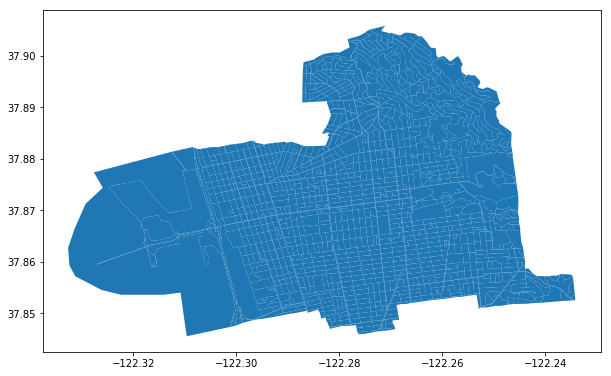

In [64]:
blocks.plot();

You can pull up the inline help to get a quick view of the options for the plot command.  

In [67]:
blocks.plot?

But note that since this is using Matplotlib under the hood, you also have access to Matplotlib arguments.  Here we et the edgecolor and linewidth using Matplotlib arguments for pyplot:
https://matplotlib.org/api/pyplot_api.html#module-matplotlib.pyplot

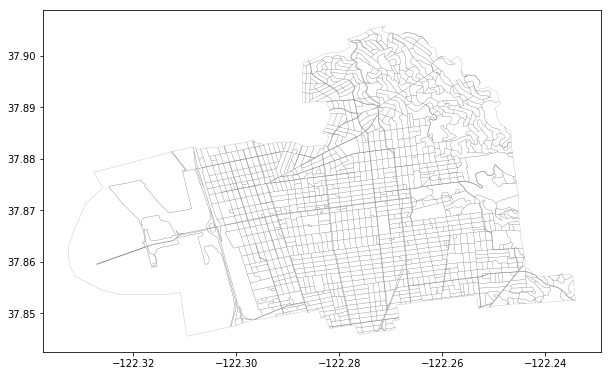

In [7]:
blocks.plot(color='none', edgecolor='gray', linewidth=.2);

### Dealing With Coordinate Reference Systems (CRS)

With geospatial data, you have to be aware of the coordinate system the data is stored in.  Latitude - Longitude is in spherical coordinates, from -180 to 180 Longitude, and -180 to 180 Latitude.  For most purposes that require working with more localized data at an urban scale, spatial datasets are generally projected on to a coordinate system that is appropriate for measurements on a flat surface.

Geopandas let's you easily find out the crs of a dataset, and change it to another (project the dataset) as needed.

In [68]:
blocks.crs

{'init': 'epsg:4326'}

### Our First Geoprocessing Step: Dissolve

Let's say we want to create a census tract dataset from the census block one, which we can see from inspecting the data above, contains a column called tractce10, for 2010 census tracts.  We can verify it by looking more closely at the geoid10 field, which appears to be a FIPS code.

Geoprocessing steps like dissolve do geometric processing on the geometry column of a GeoSeries or GeoDataFrame (which contains a GeoSeries column).

In [69]:
blocks.head()

,countyfp10,intptlon10,blockce10,tractce10,intptlat10,name10,geoid10,aland10,awater10,mtfcc10,statefp10,geometry
0,001,-122.2564001,2005,422500,+37.8760481,Block 2005,060014225002005,10537.0,0.0,G5040,06,POLYGON ((-122.2559250023598 37.87657699839653...
1,001,-122.2630010,3001,422800,+37.8677659,Block 3001,060014228003001,11761.0,0.0,G5040,06,POLYGON ((-122.2623200015607 37.86739199965932...
2,001,-122.2638664,3008,422800,+37.8658164,Block 3008,060014228003008,10506.0,0.0,G5040,06,POLYGON ((-122.2631899979306 37.86544400118984...
3,001,-122.2636773,3009,423602,+37.8621680,Block 3009,060014236023009,19893.0,0.0,G5040,06,POLYGON ((-122.2631229990616 37.86270099893191...
4,001,-122.2602461,2000,422800,+37.8681223,Block 2000,060014228002000,21110.0,0.0,G5040,06,POLYGON ((-122.2609539987092 37.86850499895072...


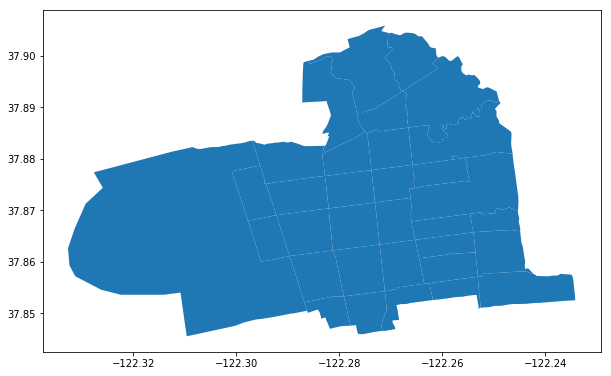

In [9]:
tracts = blocks.dissolve(by='tractce10')
tracts.plot();

In [108]:
tracts.head()

,geometry,countyfp10,intptlon10,blockce10,intptlat10,name10,geoid10,aland10,awater10,mtfcc10,statefp10
tractce10,,,,,,,,,,,
421100,POLYGON ((-122.2656260011422 37.89447000181859...,001,-122.2674866,1003,+37.9027036,Block 1003,060014211001003,38637.0,0.0,G5040,06
421200,"POLYGON ((-122.272511001732 37.89024500110148,...",001,-122.2738568,2031,+37.8905923,Block 2031,060014212002031,1001.0,0.0,G5040,06
421300,POLYGON ((-122.2826779989936 37.88124899880757...,001,-122.2800289,1016,+37.8946257,Block 1016,060014213001016,22880.0,0.0,G5040,06
421400,POLYGON ((-122.2668380004826 37.88819300118777...,001,-122.2762701,2005,+37.8875182,Block 2005,060014214002005,929.0,0.0,G5040,06
421500,POLYGON ((-122.2661620001346 37.88608300110354...,001,-122.2558725,1015,+37.8963428,Block 1015,060014215001015,3894.0,0.0,G5040,06


### Setting the crs of GeoDataFrames

Let's see what the crs is for the newly created dataset, and what it's type is.

In [70]:
print(tracts.crs)
print(type(tracts))

{'init': 'epsg:4326'}
<class 'geopandas.geodataframe.GeoDataFrame'>


OK, so dissolve created a new GeoDataFrame, but if you are using a version of Geopandas 0.2.1 or earlier, it did not assign it a crs.  We will need the crs to be set if we want to do other spatial operations on the tract dataset, so let's set it.  

In [71]:
tracts.crs = {'init' :'epsg:4326'}
# or alternatively:
tracts.crs = blocks.crs
print(tracts.crs)

{'init': 'epsg:4326'}


### Loading 311 Cases for Grafitti and Vandalism as Point Data

Let's load 311 data for graffiti and vandalism, droppin rows that have missing data (a good fraction of the data seem to be missing latitude and longitude)

In [72]:
vandalism = pd.read_csv('data/311_Cases.csv').dropna()
vandalism.head()

,Case_ID,Date_Opened,Case_Status,Date_Closed,Request_Category,Request_SubCategory,Request_Detail,Object_Type,APN,Street_Address,City,State,Neighborhood,InDbDate,Latitude,Longitude,Location
3,121000245255,05/08/2015 03:46:52 PM,Closed,05/11/2015 08:07:42 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,057 205701202,1901 HEARST AVE,Berkeley,CA,Berkeley,10/27/2016 04:12:43 AM,37.873666,-122.272719,"(37.873666, -122.272719)"
4,121000282834,02/04/2016 12:48:53 PM,Closed,08/22/2016 11:14:35 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,053 165802200,2827 SEVENTH ST,Berkeley,CA,Berkeley,10/27/2016 04:14:21 AM,37.854388,-122.291846,"(37.854388, -122.291846)"
6,121000291163,04/01/2016 02:32:13 PM,Closed,04/28/2016 01:57:26 PM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,056 192000701,1322 CHANNING WAY,Berkeley,CA,Berkeley,10/27/2016 04:14:38 AM,37.863296,-122.285123,"(37.863296, -122.285123)"
14,121000254095,07/15/2015 04:41:04 PM,Closed,07/17/2015 12:47:16 PM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,058 217102600,1631 M L KING JR WAY,Berkeley,CA,Berkeley,10/27/2016 04:13:03 AM,37.876757,-122.273231,"(37.876757, -122.273231)"
17,121000197476,06/06/2014 07:08:52 AM,Closed,06/12/2014 11:59:16 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,059 232701100,1484 SEVENTH ST,Berkeley,CA,Berkeley,10/27/2016 04:17:44 AM,37.875817,-122.299396,"(37.875817, -122.299396)"


In [73]:
type(vandalism)

pandas.core.frame.DataFrame

We loaded a csv into a standard pandas DataFrame.  But it contains Latitude, Longitude columns, so with a couple of additional steps we can turn this into a GeoDataFrame, and set its crs.

Study this example carefully.  It would be a pretty common way to encounter spatial data in tabular form that you can quickly turn into a mappable GeoDataFrame.  Note the use of zip and list comprehension to pull the Latitude and Longitude columns together to define Point geometry.

In [74]:
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(vandalism.Longitude, vandalism.Latitude)]
geovandalism = GeoDataFrame(vandalism, crs=crs, geometry=geometry)
geovandalism.head()

,Case_ID,Date_Opened,Case_Status,Date_Closed,Request_Category,Request_SubCategory,Request_Detail,Object_Type,APN,Street_Address,City,State,Neighborhood,InDbDate,Latitude,Longitude,Location,geometry
3,121000245255,05/08/2015 03:46:52 PM,Closed,05/11/2015 08:07:42 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,057 205701202,1901 HEARST AVE,Berkeley,CA,Berkeley,10/27/2016 04:12:43 AM,37.873666,-122.272719,"(37.873666, -122.272719)",POINT (-122.2727192 37.87366564)
4,121000282834,02/04/2016 12:48:53 PM,Closed,08/22/2016 11:14:35 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,053 165802200,2827 SEVENTH ST,Berkeley,CA,Berkeley,10/27/2016 04:14:21 AM,37.854388,-122.291846,"(37.854388, -122.291846)",POINT (-122.29184559 37.85438802)
6,121000291163,04/01/2016 02:32:13 PM,Closed,04/28/2016 01:57:26 PM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,056 192000701,1322 CHANNING WAY,Berkeley,CA,Berkeley,10/27/2016 04:14:38 AM,37.863296,-122.285123,"(37.863296, -122.285123)",POINT (-122.28512347 37.86329594)
14,121000254095,07/15/2015 04:41:04 PM,Closed,07/17/2015 12:47:16 PM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,058 217102600,1631 M L KING JR WAY,Berkeley,CA,Berkeley,10/27/2016 04:13:03 AM,37.876757,-122.273231,"(37.876757, -122.273231)",POINT (-122.27323113 37.87675705)
17,121000197476,06/06/2014 07:08:52 AM,Closed,06/12/2014 11:59:16 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,059 232701100,1484 SEVENTH ST,Berkeley,CA,Berkeley,10/27/2016 04:17:44 AM,37.875817,-122.299396,"(37.875817, -122.299396)",POINT (-122.29939598 37.87581733)


In [75]:
print(type(geovandalism))
print(geovandalism.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
{'init': 'epsg:4326'}


OK, now it looks good, so let's see what it looks like mapped.

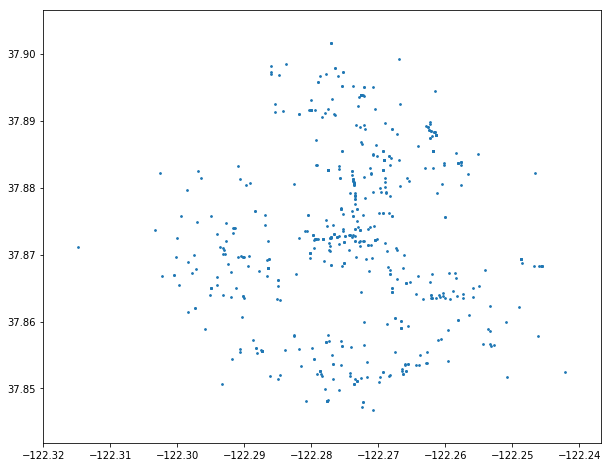

In [76]:
geovandalism.plot(markersize=3);

### Mapping With Layers

A bunch of points mapped is not very informative, since it lacks context.  Let's add the points to the block base to add visual context.

NOTE: the maps are going to be pretty slow if you are using Geopandas 0.2.1 -- there were substantial improvements in performance in versin 0.3.0.  These performance issues are especially pronounced when we get to more detailed data and maps.  Note the circle in the upper right of the Jupyter notebook that goes solid while Python is running. Just wait for it to go white again, and you'll see maps appear.

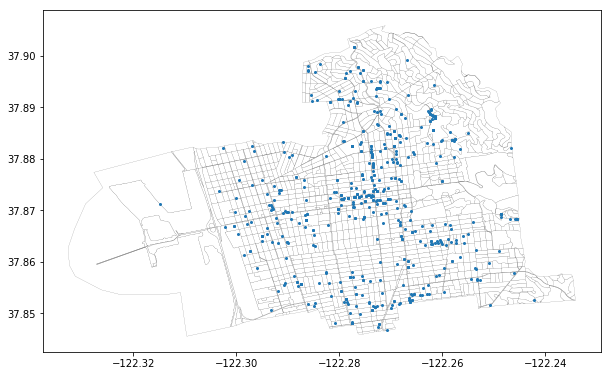

In [77]:
base = blocks.plot(color='white', edgecolor='black', linewidth=.1)
geovandalism.plot(ax=base, markersize=4);

### Projecting to a Different crs

So far our data has been in world coordinates, but we will be doing some spatial analysis, so it is time to project them to a coordinate system that allows more meaningful measurements of distance.  We will use the MTC standardized crs for this tutorial.

In [78]:
print(blocks.crs)

{'init': 'epsg:4326'}


MTC has standardized on Universal Transverse Mercator (UTM), Zone 10N, NAD83 for all analysis based projects.
Let's reproject these data from 4326 to the MTC crs, using 'to_crs'.  There are several different formats that can be used to set the crs parameters.  Details are beyond the scope of today's tutorial so please consult other sources for more detailed explanations, such as spatialreference.org.

In [240]:
# http://spatialreference.org/ref/sr-org/6787/
mtc_crs = '+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs '
geovandalism_proj = geovandalism.to_crs(mtc_crs)
blocks_proj = blocks.to_crs(mtc_crs)
tracts_proj = tracts.to_crs(mtc_crs)
tracts_proj.crs

'+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs '

### Getting the Bounds of a GeoDataFrame

One thing you may need to do at times is find the bounds of your dataset.  You can do that by feature (bounds) or for the whole dataset (total_bounds) like this:

In [80]:
bounds = tracts_proj.total_bounds
print(bounds)

[  558702.20665035  4188902.46468913   567371.41840041  4195616.51058903]


### Some plotting options: turning the axes off, changing figure size, saving an image

Let's say you are generating a map you want to put into a blog or a report.  You might want to improve the aesthetics a bit by removing the bounding boxes with labels corresponding to X, Y coordinates since they are generally not that visually useful.  You can also add a title and save the figure as an image.

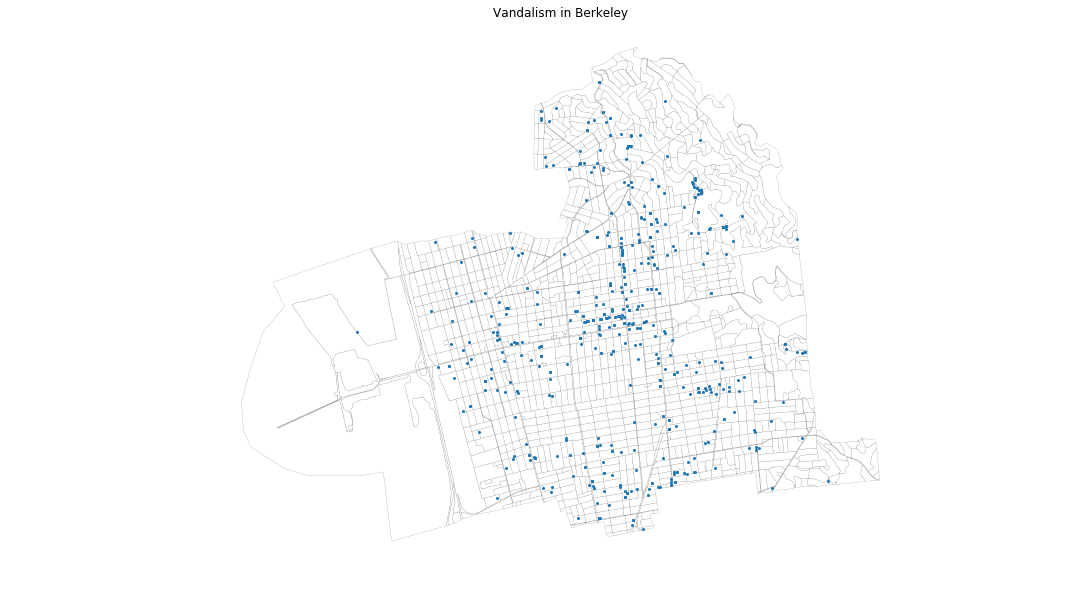

In [81]:
f, ax = plt.subplots(1, figsize=(18, 10))
ax.set_title('Vandalism in Berkeley')
DPI=100

ax = blocks_proj.plot(ax=ax, color='white', edgecolor='black', linewidth=.1)
geovandalism_proj.plot(ax=ax, markersize=4)
ax.set_axis_off()
plt.axis('equal');
plt.savefig('vandalism.png', dpi=DPI, bbox_inches='tight')


### Using Intersect to Assign Polygon ID and Attributes to Points

A very common geoprocessing operation is to do a point in polygon assignment using an intersection of the geometries of points and polygons.  It is like a spatial merge, where the two datasets do not have a common key to merge on, but have coordinates that enable geometric processing to figure out which polygon each point falls within.

GeoPandas makes this pretty easy using a spatial join, or 'sjoin' function with an 'intersects' operation argument.

You may run into more installation issues here since this requires a spatial indexing library, rtree, which in turn requires a compiled C library.  On most machines the standard pip install geopandas will install these dependencies. But it seems not to on a mac.

In [24]:
# If you get an error in the cell below this one, uncomment the pip install line here and run it
#!pip install rtree

In [82]:
geovandalism_proj_blocks = gpd.sjoin(geovandalism_proj, blocks_proj, how="inner", op='intersects')
geovandalism_proj_blocks.head()

,Case_ID,Date_Opened,Case_Status,Date_Closed,Request_Category,Request_SubCategory,Request_Detail,Object_Type,APN,Street_Address,...,intptlon10,blockce10,tractce10,intptlat10,name10,geoid10,aland10,awater10,mtfcc10,statefp10
3,121000245255,05/08/2015 03:46:52 PM,Closed,05/11/2015 08:07:42 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,057 205701202,1901 HEARST AVE,...,-122.2726875,2002,422400,+37.8738479,Block 2002,060014224002002,9514.0,0.0,G5040,06
576,121000245291,05/11/2015 08:06:20 AM,Closed,05/27/2015 03:07:12 PM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Traffic Maintenance,Property,057 205701202,1901 HEARST AVE,...,-122.2726875,2002,422400,+37.8738479,Block 2002,060014224002002,9514.0,0.0,G5040,06
1137,121000308818,08/07/2016 10:28:57 AM,Closed,08/24/2016 08:20:27 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,057 205701202,1901 HEARST AVE,...,-122.2726875,2002,422400,+37.8738479,Block 2002,060014224002002,9514.0,0.0,G5040,06
1159,121000209814,08/26/2014 03:46:38 PM,Closed,08/28/2014 07:10:24 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,057 205700100,1801 M L KING JR WAY,...,-122.2726875,2002,422400,+37.8738479,Block 2002,060014224002002,9514.0,0.0,G5040,06
4,121000282834,02/04/2016 12:48:53 PM,Closed,08/22/2016 11:14:35 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,053 165802200,2827 SEVENTH ST,...,-122.2916534,1077,422000,+37.8545176,Block 1077,060014220001077,20096.0,0.0,G5040,06


### Aggregating data using Groupby

Let's say we want to look at the incidence of vandalism events at some level of geography like neighborhood or census tract rather than just looking at the raw data.  We can use groupby operations to get the counts of events within each geographic area, then merge it on to a Geodataframe to visualize it.

In [104]:
tract_v = geovandalism_proj_blocks.groupby('tractce10')['Case_ID'].count().to_frame(name='total_vandalism').reset_index()
tract_v.head()

,tractce10,total_vandalism
0,421100,1
1,421200,33
2,421300,26
3,421400,11
4,421500,33


In [110]:
tracts2 = pd.merge(tracts,tract_v, left_index=True, right_on='tractce10')
tracts2.head()

,geometry,countyfp10,intptlon10,blockce10,intptlat10,name10,geoid10,aland10,awater10,mtfcc10,statefp10,tractce10,total_vandalism
0,POLYGON ((-122.2656260011422 37.89447000181859...,001,-122.2674866,1003,+37.9027036,Block 1003,060014211001003,38637.0,0.0,G5040,06,421100,1
1,"POLYGON ((-122.272511001732 37.89024500110148,...",001,-122.2738568,2031,+37.8905923,Block 2031,060014212002031,1001.0,0.0,G5040,06,421200,33
2,POLYGON ((-122.2826779989936 37.88124899880757...,001,-122.2800289,1016,+37.8946257,Block 1016,060014213001016,22880.0,0.0,G5040,06,421300,26
3,POLYGON ((-122.2668380004826 37.88819300118777...,001,-122.2762701,2005,+37.8875182,Block 2005,060014214002005,929.0,0.0,G5040,06,421400,11
4,POLYGON ((-122.2661620001346 37.88608300110354...,001,-122.2558725,1015,+37.8963428,Block 1015,060014215001015,3894.0,0.0,G5040,06,421500,33


### Choroplethic Maps

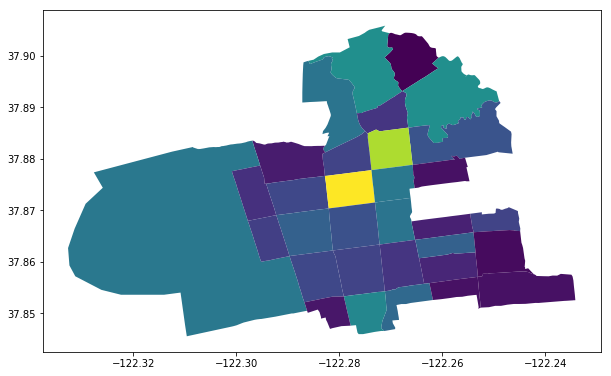

In [118]:
tracts2.plot(column='total_vandalism')

The default colormap is not very useful in this case. We can select a colormap (cmap) to make this more interpretable.

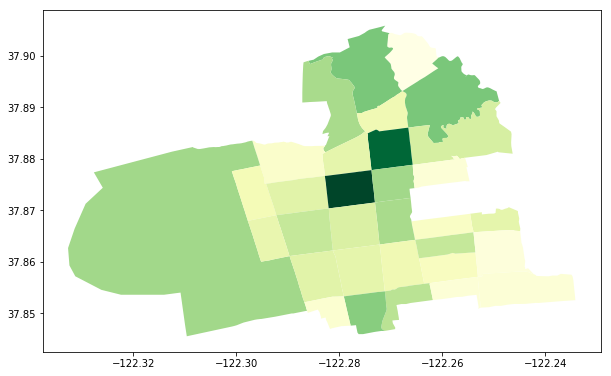

In [131]:
tracts2.plot(column='total_vandalism', cmap='YlGn')

You can find all the colormap options in the Matplotlib documentation here: http://matplotlib.org/users/colormaps.html

### Normalizing by Area

One issue that is a common problem with choroplethic or thematic maps is that polygons with larger areas tend to show up more prominently than might be appropriate, just because they are larger in geographic area.  We often want to normalize our data by area to compute a density to offset this.  Geopandas gives us access to an attribute of the geometry of polygons to get the areas, so this is fairly straightforward to do.

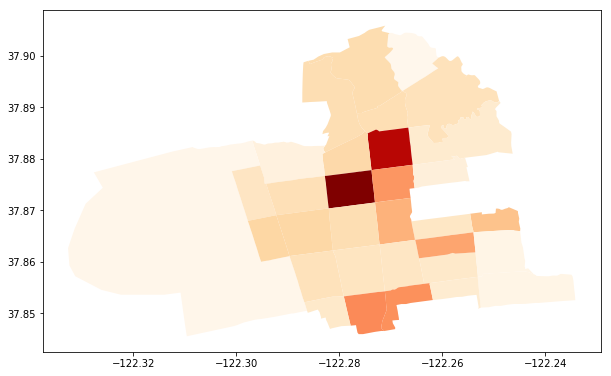

In [116]:
tracts2['van_sqmi'] = tracts2['total_vandalism']/tracts2.area/27878400
tracts2.plot(column='van_sqmi', cmap='OrRd')

### Generating Heatmaps

If we wanted to avoid aggregating the data into somewhat arbitrary geographies like census tracts, we might want to see an overall spatial pattern from the density or values of the point data using a form of spatial smoothing, called a heat map. It works best if you can overlay the heatmap on another layer for context. Let's adapt an example from the Geopandas site here to do this: http://nbviewer.jupyter.org/gist/perrygeo/c426355e40037c452434

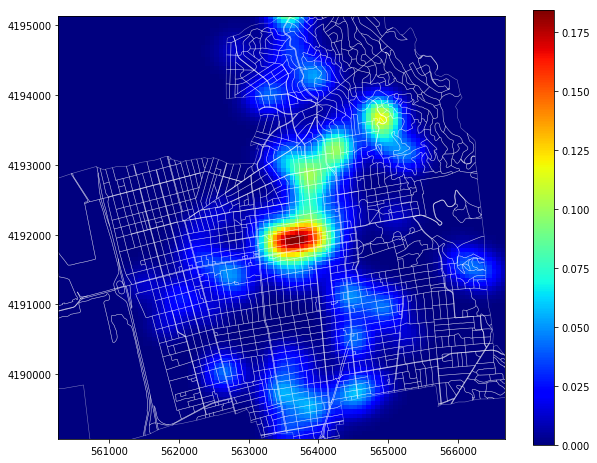

In [139]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    #return logheatmap
    blocks_proj.plot(color='none', edgecolor='white', linewidth=.5, alpha=.5)

    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

heatmap(geovandalism_proj_blocks, bins=100, smoothing=3)

### Loading BART Stations

Let's try to set up some analysis of proximity to BART stations in Berkeley. First, we load a shapefile of BART stations retrieved from CALTRANS.

In [140]:
bart = gpd.read_file('data/BART_Sta_13.shp')
bart.head()

,STATION,OPERATOR,DIST,CO,geometry
0,NORTH BERKELEY,BART,4,ALA,POINT (-122.283347881478 37.87406119520771)
1,DOWNTOWN BERKELEY,BART,4,ALA,POINT (-122.268249538332 37.86968943870814)
2,ASHBY,BART,4,ALA,POINT (-122.2701189608313 37.85320737930983)
3,ROCKRIDGE,BART,4,ALA,POINT (-122.2517773834424 37.84450968784791)
4,MACARTHUR,BART,4,ALA,POINT (-122.2671204422818 37.82870504871252)


In [141]:
print(bart.crs)

{'init': 'epsg:4269'}


Ok so this is in a different projection and we will need to convert it if we want to interact with this and our other data.

In [144]:
bart_proj = bart.to_crs(blocks_proj.crs)

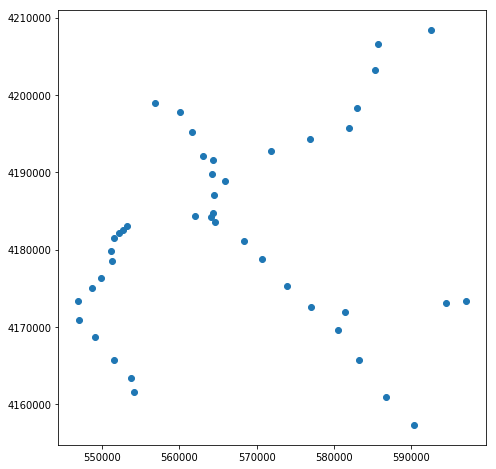

In [145]:
bart_proj.plot()

### Spatial Overlays

Spatial joins and overlays are very similar. Joins are like merges in Pandas but with GeoDataFrames, so they result in different sets being included in the resulting merge.  Spatial joins are useful for merging point and polygon layers for example, by identifying which points fall into which polygons, and then determining what to do about these relationships based on the operation requested.  

Overlays are more general geoprocessing operations using set theory to produce a geometric result that contains different combinations of the inputs, and are particularly useful if you want to operate on two polygon sets or lines and polygons.

We woud import the relevant methods like this:

from geopandas.tools import overlay

The geopandas.tools.overlay function takes three arguments:

* df1
* df2
* how

Where how can be one of:

['intersection',
'union',
'identity',
'symmetric_difference',
'difference']

These correspond in set theory to A & B, A or B, A, Not (A or B),  A & (Not B):

| Operation    | Set Equivalent |
|--------------|----------------|
| Intersection | A & B |
| Union        | A or B |
| Identity     | A      |
| Symmetric Difference | Not (A or B) |
| Difference | A & (Not B) |

Below, courtesy of QGIS documentation, is a visual explanation of the different kinds of spatial overlay operations.


In [148]:
from IPython.core.display import Image 
Image(url="http://docs.qgis.org/testing/en/_images/overlay_operations.png")

### Spatial Joins: Intersecting Regional BART Stations to Get Only Berkeley Stations

We only want to keep the stations in Berkeley.  We could do it by selecting the stations by name, but that wouldn't give us a chance to exercise doing spatial joins, so let's do that instead.

We have three argument options we could use:
* intersects
* within
* contains

Experiment to see what happens if you use point data or polygon data as the left Geodataframe.  What type of geometry do you end up with?

In [161]:
bart_berkeley = gpd.sjoin(bart_proj, blocks_proj, how="inner", op='intersects')
bart_berkeley

,STATION,OPERATOR,DIST,CO,geometry,index_right,countyfp10,intptlon10,blockce10,tractce10,intptlat10,name10,geoid10,aland10,awater10,mtfcc10,statefp10
0,NORTH BERKELEY,BART,4,ALA,POINT (563028.0000003229 4192083.999982029),264,001,-122.2834613,1018,422200,+37.8738420,Block 1018,060014222001018,14222.0,0.0,G5040,06
1,DOWNTOWN BERKELEY,BART,4,ALA,POINT (564359.6875347332 4191609.250012103),882,001,-122.2692393,2013,422900,+37.8697012,Block 2013,060014229002013,22107.0,0.0,G5040,06
2,ASHBY,BART,4,ALA,POINT (564209.5624836758 4189779.249962593),1167,001,-122.2702939,2003,423901,+37.8533054,Block 2003,060014239012003,29324.0,0.0,G5040,06


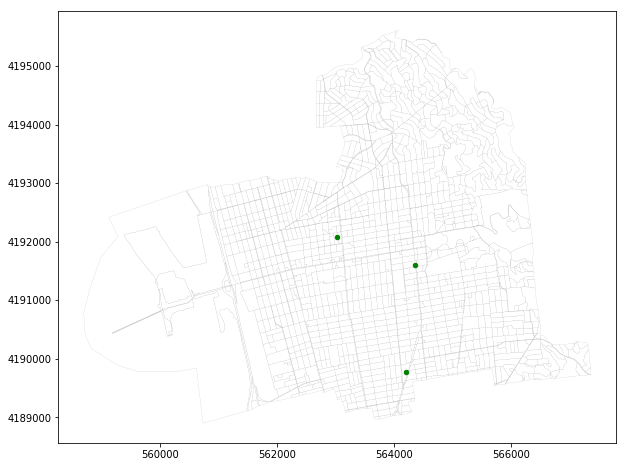

In [162]:
base = blocks_proj.plot(color='white', edgecolor='gray', linewidth=.1)
bart_berkeley.plot(ax=base, color='green', markersize = 20);

### Generate Buffers Around BART Stations

We often want to analyze what is close to a transit station, so let's create 1/2 Kilometer buffers around our BART stations.  Let's double-check our CRS to see what units we are using so we can decide what the buffer should be.

In [165]:
bart_berkeley.crs

'+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs '

OK, we're using meters so 1/2 KM gives us a buffer distance of 500 in meter units.

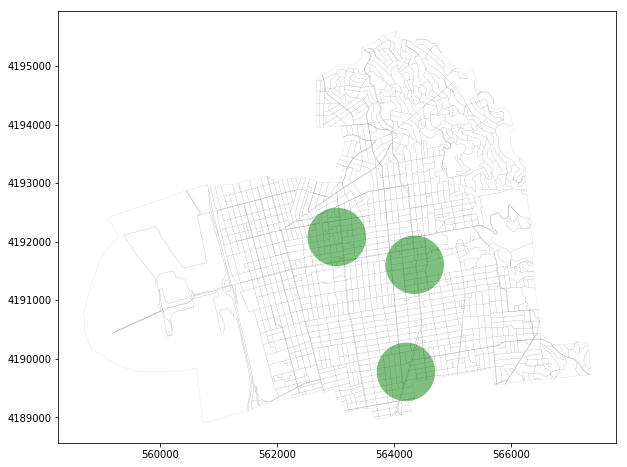

In [166]:
bart_buffer = bart_berkeley['geometry'].buffer(500)
base = blocks_proj.plot(color='none', edgecolor='gray', linewidth=.1)
bart_buffer.plot(ax=base, color='green', alpha=.5);

### Making a GeoDataFrame from a GeoSeries

Some spatial operations are easier to handle if the data are GeoDataFrames.  The buffering operation creates a GeoSeries.  Let's inspect it.

In [171]:
print(bart_buffer)

0    POLYGON ((563528.0000003229 4192083.999982029,...
1    POLYGON ((564859.6875347332 4191609.250012103,...
2    POLYGON ((564709.5624836758 4189779.249962593,...
dtype: object


Below we create a GeoDataFrame from the buffers.  We also label them.  I inferred the names from the relative coordinates.

In [176]:
bart_buffer_df = gpd.GeoDataFrame({'geometry': bart_buffer, 'bart_buffer_df':['North \n Berkeley','Downtown \n Berley','Ashby']})
print(bart_buffer_df)

       bart_buffer_df                                           geometry
0   North \n Berkeley  POLYGON ((563528.0000003229 4192083.999982029,...
1  Downtown \n Berley  POLYGON ((564859.6875347332 4191609.250012103,...
2               Ashby  POLYGON ((564709.5624836758 4189779.249962593,...


Below we assign the crs since it is already projected (you can look at the coordinates in the geometry column to verify).  The buffering operation just does not retain the crs.

In [37]:
print(bart_buffer_df.crs)

None


In [38]:
bart_buffer_df.crs = blocks_proj.crs
print(bart_buffer_df.crs)

+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs 


### Adding Annotation to a Map - Bart Station Names

Below we find a representative point inside each BART station buffer, and use it to position a label centered inside the buffer, with the Station Name.

In [178]:
bart_buffer_df['coords'] = bart_buffer_df['geometry'].apply(lambda x: x.representative_point().coords[:])
bart_buffer_df['coords'] = [coords[0] for coords in bart_buffer_df['coords']]
print(bart_buffer_df.columns)
print(bart_buffer_df)

Index(['bart_buffer_df', 'geometry', 'coords'], dtype='object')
       bart_buffer_df                                           geometry  \
0   North \n Berkeley  POLYGON ((563528.0000003229 4192083.999982029,...   
1  Downtown \n Berley  POLYGON ((564859.6875347332 4191609.250012103,...   
2               Ashby  POLYGON ((564709.5624836758 4189779.249962593,...   

                                    coords  
0  (563028.0000003229, 4192108.5042671114)  
1  (564359.6875347332, 4191633.7542971857)  
2  (564209.5624836758, 4189803.7542476756)  


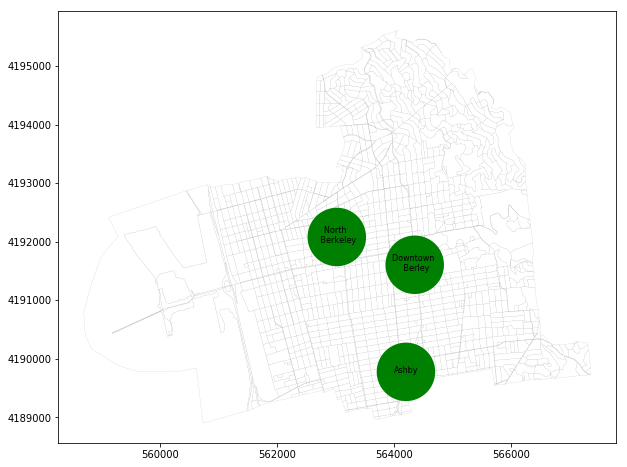

In [179]:
base = blocks_proj.plot(color='white', edgecolor='gray', linewidth=.1)
bart_buffer.plot(ax=base, color='green', markersize = 5)
for idx, row in bart_buffer_df.iterrows():
    plt.annotate(s=row['bart_buffer_df'], xy=row['coords'],
                 horizontalalignment='center', verticalalignment='center', fontsize=8)

## GeoDataFrame to and from GeoJSON 

If you want to use your data in some form that requires GeoJSON, for example to create a Carto or Leaflet map, it is simple to export the GeoDataFrame to GeoJSON.  First we will just print the GeoJSON output, then we will write it to a file.  Finally, we will read it back in to a GeoDataFrame to ensure that it is working in both directions.

In [180]:
import pprint
pprint.pprint(bart_buffer_df.to_json())

('{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", '
 '"properties": {"bart_buffer_df": "North \\n Berkeley", "coords": '
 '[563028.0000003229, 4192108.5042671114]}, "geometry": {"type": "Polygon", '
 '"coordinates": [[[563528.0000003229, 4192083.999982029], [563525.5923636591, '
 '4192034.9914118643], [563518.3926405245, 4191986.4548210213], '
 '[563506.470168189, 4191938.857643402], [563489.9397665786, '
 '4191892.658265847], [563468.9606324971, 4191848.3016136163], '
 '[563443.7348064742, 4191806.214865519], [563414.5052270043, '
 '4191766.8033399475], [563381.5533909162, 4191730.446591436], '
 '[563345.1966424048, 4191697.4947553477], [563305.7851168327, '
 '4191668.265175878], [563263.698368736, 4191643.039349855], '
 '[563219.3417165055, 4191622.0602157735], [563173.1423389502, '
 '4191605.529814163], [563125.545161331, 4191593.6073418274], '
 '[563077.0085704877, 4191586.407618693], [563028.0000003229, '
 '4191583.999982029], [562978.9914301581, 4191586.

In [181]:
with open('bart_buffer_df.geojson', 'w') as f:
    f.write(bart_buffer_df.to_json())

test = GeoDataFrame.from_file('bart_buffer_df.geojson')
test.head()


,id,bart_buffer_df,geometry
0,0,North \n Berkeley,"POLYGON ((563528.0000003229 4192083.999982029,..."
1,1,Downtown \n Berley,"POLYGON ((564859.6875347332 4191609.250012103,..."
2,2,Ashby,"POLYGON ((564709.5624836758 4189779.249962593,..."


### Your Turn

To practice with Geopandas, experiment with the methods covered so far with data you are interested in working with on your project, or any other data you can find readily from an Open Data Portal like Berkeley, San Francisco, Oakland, New York, or others.

* Download a shapefile containing point data and attributes
* Create a GeoDataFrame
* Set its CRS
* Plot it with color coding of the points based on the values of an attribute
* Download a shapefile containing polygons and attributes
* Create a GeoDataFrame
* Plot a Choroplethic Map
* Change the coordinate procjetion on these from spherical to a projected coordinate system
* Do a spatial join of the point and polygon data
* Aggregate the joined data to summarize it
